# Simulation with AR data

In [1]:
%load_ext lab_black

In [1]:
import pandas as pd
from scipy import stats
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
import seaborn as sns

import pickle
import time
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split

# comparative classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# evaluation classifier
from rerf.rerfClassifier import rerfClassifier
import control
import sys

sys.path.append("../")

from sample_code.simulation.lds import DiscreteLinearSystem

print(sys.version)
import warnings

warnings.simplefilter("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]


# Parameters and Directories for Simulation

In [2]:
seed = 12345

In [30]:
# length of data sequence
ns = np.array([50, 100, 200, 400, 1000])

nchs = 6  # number of channels in each MTS
test_size = 0.5  # size of the test data
random_state = 1234  # random state to separate training/testing samples
np.random.seed(random_state)

T = 100  # number of time steps for each sequence

# assume you can train on half trials and
# test on half the trials
test_size = 0.5

# number of samples
n_samples = 100

# simulated data parameters
n_trials = 100

# number of times to repeat experiment for estimating CI
num_runs = 10

# dimensionality of data and noise
data_dim = 3
noise_dim = 3
n_chs = data_dim + noise_dim

snr_factor = 1.0

# data mean vector
mu = np.zeros((data_dim,))

# permutation strategy
permutation_strategy = "alternate"

In [31]:
root = Path("/home/adam2392/hdd/Dropbox/morf-study/")
deriv_root = root / "derivatives"

study_path = deriv_root / "mtmorf-simulation"

# Simulation of AR(1) Data

In [15]:
def _generate_random_input_pulse(n_chs, n_steps):
    """Apply an input signal for approximately 5 time points.

    The point at which the impulse signal is applied varies
    randomly between K and 2K.
    """
    # generate a C x T array
    ut = np.zeros((n_chs, n_steps))

    # randomly select a time point around the center
    # center_time = n_steps // 2
    K = 20
    rand_ind = np.random.randint(K, 2 * K, size=None)
    ut[:, rand_ind : rand_ind + 5] = 1

    # ut[:, center_time:center_time+2] = 1

    return ut


def generate_ar_samples2(cls=0, n_steps=1000, k=1):
    """
    Generate multivariate time-series for 3 channels of length n_samples
    from a vector AR(1) model. Uncorrelated white noise channels are
    interspersed between the vector sequences.

    VAR(1) Model:
    y(t+1) = Ay(t) + Bu(t) + err(t)

    The noise is additive, not multiplicative.
    """
    n_chs = 3
    n_noise_chs = 3

    # scale data along time w/ normalization
    scaler = StandardScaler()

    A = np.array(
        [
            [1.0, 0.7 * k, 0.6 * k],
            [-0.5 * k, 0.9, 0.5 * k],
            [-0.6 * k, -0.7 * k, 0.8],
        ]
    )
    A = A / np.linalg.norm(A, ord=2)

    # signal that separates binary classes
    if cls == 0:
        B = np.array([[0.5, 0.1 * k, 0.1 * k], [0, 0.5, 0.1 * k], [0, 0, -0.5]])
    elif cls == 1:
        B = np.array([[0.5, 0, 0], [0, 0.5, 0], [0, 0, -0.5]])

    # create DT Linear system
    linsys = DiscreteLinearSystem(A=A, B=B)

    # generate input
    ut = _generate_random_input_pulse(n_chs, n_steps)
    #     print(ut.shape)
    # generate random initial condition and simulate what system would look like
    x0 = np.random.random((n_chs,))
    y = linsys.reconstruct(x0, ut, steps=n_steps, add_noise=False)
    assert y.shape == (n_chs, n_steps)
    #     print(np.linalg.norm(A))

    C = control.ctrb(A, B)
    #     print(C.shape)
    #     print(np.linalg.matrix_rank(C))
    assert np.linalg.norm(A, ord=2) <= 1
    assert np.linalg.matrix_rank(C) == 3

    # add iid noise to the system simulation
    y_noise = np.random.normal(
        scale=0.5, size=(n_noise_chs, n_steps)
    )  # add Gaussian noise?
    # print(f"max: {np.max(y)}, min: {np.min(y)}")
    y = y + y_noise

    # stack noise
    y_noise = np.random.random((n_noise_chs, n_steps))
    y = np.vstack(
        (y[0, :], y_noise[0, :], y[1, :], y_noise[1, :], y[2, :], y_noise[2, :])
    )

    # normalize along the time domain
    # y = scaler.fit_transform(y.T).T
    return y

In [7]:
def simulate_data(n, T, nchs=6, cov_factor=1, test_size=0.5, random_state=None):
    # initialize data structures for train/test data
    X_train, Y_train = np.empty(shape=(0, nchs, T)), np.empty(shape=(0))
    X_test, Y_test = np.empty(shape=(0, nchs, T)), np.empty(shape=(0))

    # simulate over varying sizes of data sequence
    y = []
    X = []

    # generate correlated multi-variate time series
    for i in range(n):
        _x = generate_ar_samples2(cls=0, n_steps=T, k=cov_factor)
        X.append(_x)
        y.append(0)
    for i in range(n):
        _x = generate_ar_samples2(cls=1, n_steps=T, k=cov_factor)
        X.append(_x)
        y.append(1)
    X = np.array(X)
    y = np.array(y)

    # perform training test split
    _X_train, _X_test, _y_train, _y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    X_train = np.vstack((X_train, _X_train))
    Y_train = np.hstack((Y_train, _y_train))
    X_test = np.vstack((X_test, _X_test))
    Y_test = np.hstack((Y_test, _y_test))

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    return X_train, Y_train, X_test, Y_test

In [8]:
sig = generate_ar_samples2(cls=0, n_steps=1000, k=1)

# Setup Classifiers

In [123]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.client import device_lib

physical_devices = tf.config.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("GPUs: ", len(tf.config.experimental.list_physical_devices("GPU")))

# CNN if tensorflow is installed
# Build CNN model
n_classes = 1


def _build_cnn():

    model = models.Sequential()
    model.add(
        layers.Conv2D(
            32,
            (2, 2),
            activation="relu",
            input_shape=(n_chs, n_samples, 1),
            padding="same",
        )
    )
    model.add(layers.MaxPooling2D((2, 2), padding="same"))
    model.add(layers.Conv2D(32, (2, 2), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2, 2), padding="same"))
    model.add(layers.Conv2D(64, (2, 2), activation="relu", padding="same"))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(n_classes, activation="sigmoid"))

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            #                  tf.keras.metrics.AUC(multi_label=False)
        ],
    )
    return model

GPUs:  0


In [17]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [18]:
## Setup for run
names = {
    "Log. Reg": "blue",
    "Lin. SVM": "firebrick",
    "SVM": "purple",
    "kNN": "black",
    "RF": "#f86000",
    "MLP": "green",
    "cnn": "magenta",
    "Sporf": "red",
    "xgb": "black",
    "MT-MORF": "orange",
}

ncores = -1
num_runs = 10
n_est = 100  # number of estimators
random_state = 0

classifiers = [
    LogisticRegression(random_state=random_state, n_jobs=ncores, solver="liblinear"),
    LinearSVC(),
    SVC(C=1.0, kernel="rbf", gamma="auto", random_state=random_state),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features="auto", n_jobs=ncores),
    MLPClassifier(
        hidden_layer_sizes=(n_est,), random_state=random_state, max_iter=1000
    ),
    KerasClassifier(_build_cnn, verbose=0),
    rerfClassifier(
        projection_matrix="RerF",
        max_features="auto",
        n_jobs=ncores,
        n_estimators=n_est,
        oob_score=False,
        random_state=random_state,
    ),
    GradientBoostingClassifier(n_estimators=n_est, random_state=random_state),
    #     rerfClassifier(
    #         projection_matrix="S-Rerf",
    #         max_features="auto",
    #         n_jobs=ncores,
    #         n_estimators=n_est,
    #         oob_score=False,
    #         random_state=0,
    #         image_height=n_chs,
    #         image_width=n_samples,
    #         patch_height_max=2,
    #         patch_height_min=1,
    #         patch_width_max=20,
    #         patch_width_min=5,
    #     ),
    rerfClassifier(
        projection_matrix="MT-MORF",
        max_features="auto",
        n_jobs=ncores,
        n_estimators=n_est,
        oob_score=False,
        random_state=random_state,
        image_height=n_chs,
        image_width=n_samples,
        patch_height_max=2,
        patch_height_min=1,
        patch_width_max=20,
        patch_width_min=5,
    ),
]

In [19]:
runList = [
    (n, clf, run)
    for n in ns
    for clf in zip(classifiers, [key for key in names])
    for run in range(num_runs)
]
print(
    f"About to run {len(runList)} clf experiments: "
    f"sample size: {n_samples}, number channels: {n_chs}, "
    f"n_trials: {n_trials}, noise dim: {noise_dim}"
)

About to run 600 clf experiments: sample size: 100, number channels: 6, n_trials: 100, noise dim: 3


In [20]:

ns = np.array([50, 100, 200, 400, 1000, 2000])  # length of data sequence

n = 50

X_train, Y_train, X_test, Y_test = simulate_data(
    n, T, nchs=nchs, cov_factor=1, test_size=test_size, random_state=random_state
)
print(X_train.shape, Y_train.shape, X_test.shape)

(50, 600) (50,) (50, 600)


# Run Classification Experiment and Compare

In [21]:
fname = (
    study_path
    / f"mtorfexp_ldssimulation_snrfactor={snr_factor}_samplesize={n_samples}_ntrials={n_trials}_noisedim={noise_dim}.csv"
)

print(fname)

/home/adam2392/hdd/Dropbox/morf-study/derivatives/mtmorf-simulation/mtorfexp_ldssimulation_snrfactor=1.0_samplesize=100_ntrials=100_noisedim=3.csv


In [23]:
overwrite = False

# Train each classifier on each dataset size, then test
# Prep output file:
if not Path(fname).exists() or overwrite:
    f = open(fname, "w+")
    f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
    f.flush()
else:
    f = open(fname, "a")

for n, clf, iteration in tqdm(runList):
    #     X_train, Y_train, X_test, Y_test = generate_data(
    #         n_chs, n_samples, n_trials, ns, data_dim, noise_dim, test_size, snr_factor
    #     )

    X_train, Y_train, X_test, Y_test = simulate_data(
        n, T, nchs=nchs, cov_factor=1, test_size=test_size, random_state=random_state
    )

    if X_train.ndim == 3:
        X_train = X_train.reshape(-1, X_train.shape[-1]).T
    if X_test.ndim == 3:
        X_test = X_test.reshape(-1, X_test.shape[-1]).T
    X = X_train[:n]
    y = Y_train[:n]

    # training start time and end time
    trainStartTime = time.time()

    if isinstance(clf[0], KerasClassifier):
        X = X.reshape(-1, n_chs, n_samples, 1)
        X_test = X_test.reshape(-1, n_chs, n_samples, 1)
    # train_data = tf.data.Dataset.from_tensor_slices((X, y))
    # valid_data = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

    clf[0].fit(X, y)
    #   clf[0].fit(train_data, epochs=10, validation_data=valid_data)
    trainEndTime = time.time()
    trainTime = trainEndTime - trainStartTime

    # testing start time and end time
    testStartTime = time.time()
    out = clf[0].predict(X_test)
    testEndTime = time.time()
    testTime = testEndTime - testStartTime

    # mean-error on the test set
    lhat = np.mean(np.not_equal(out, Y_test).astype(int))
    ####("variable,Lhat,trainTime,testTime,iterate")

    clf_id = clf[1]
    outputstr_row = (
        f"{clf_id}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n"
    )
    f.write(outputstr_row)
    f.flush()

f.close()

 11%|█         | 64/600 [00:20<12:47,  1.43s/it]

 11%|█         | 65/600 [00:20<10:28,  1.17s/it]

 11%|█         | 66/600 [00:21<08:58,  1.01s/it]

 11%|█         | 67/600 [00:22<08:52,  1.00it/s]

 11%|█▏        | 68/600 [00:22<07:50,  1.13it/s]

 12%|█▏        | 69/600 [00:23<07:07,  1.24it/s]

 27%|██▋       | 160/600 [00:45<02:42,  2.71it/s]

 27%|██▋       | 161/600 [00:49<10:15,  1.40s/it]

100%|██████████| 600/600 [22:45<00:00,  2.28s/it]


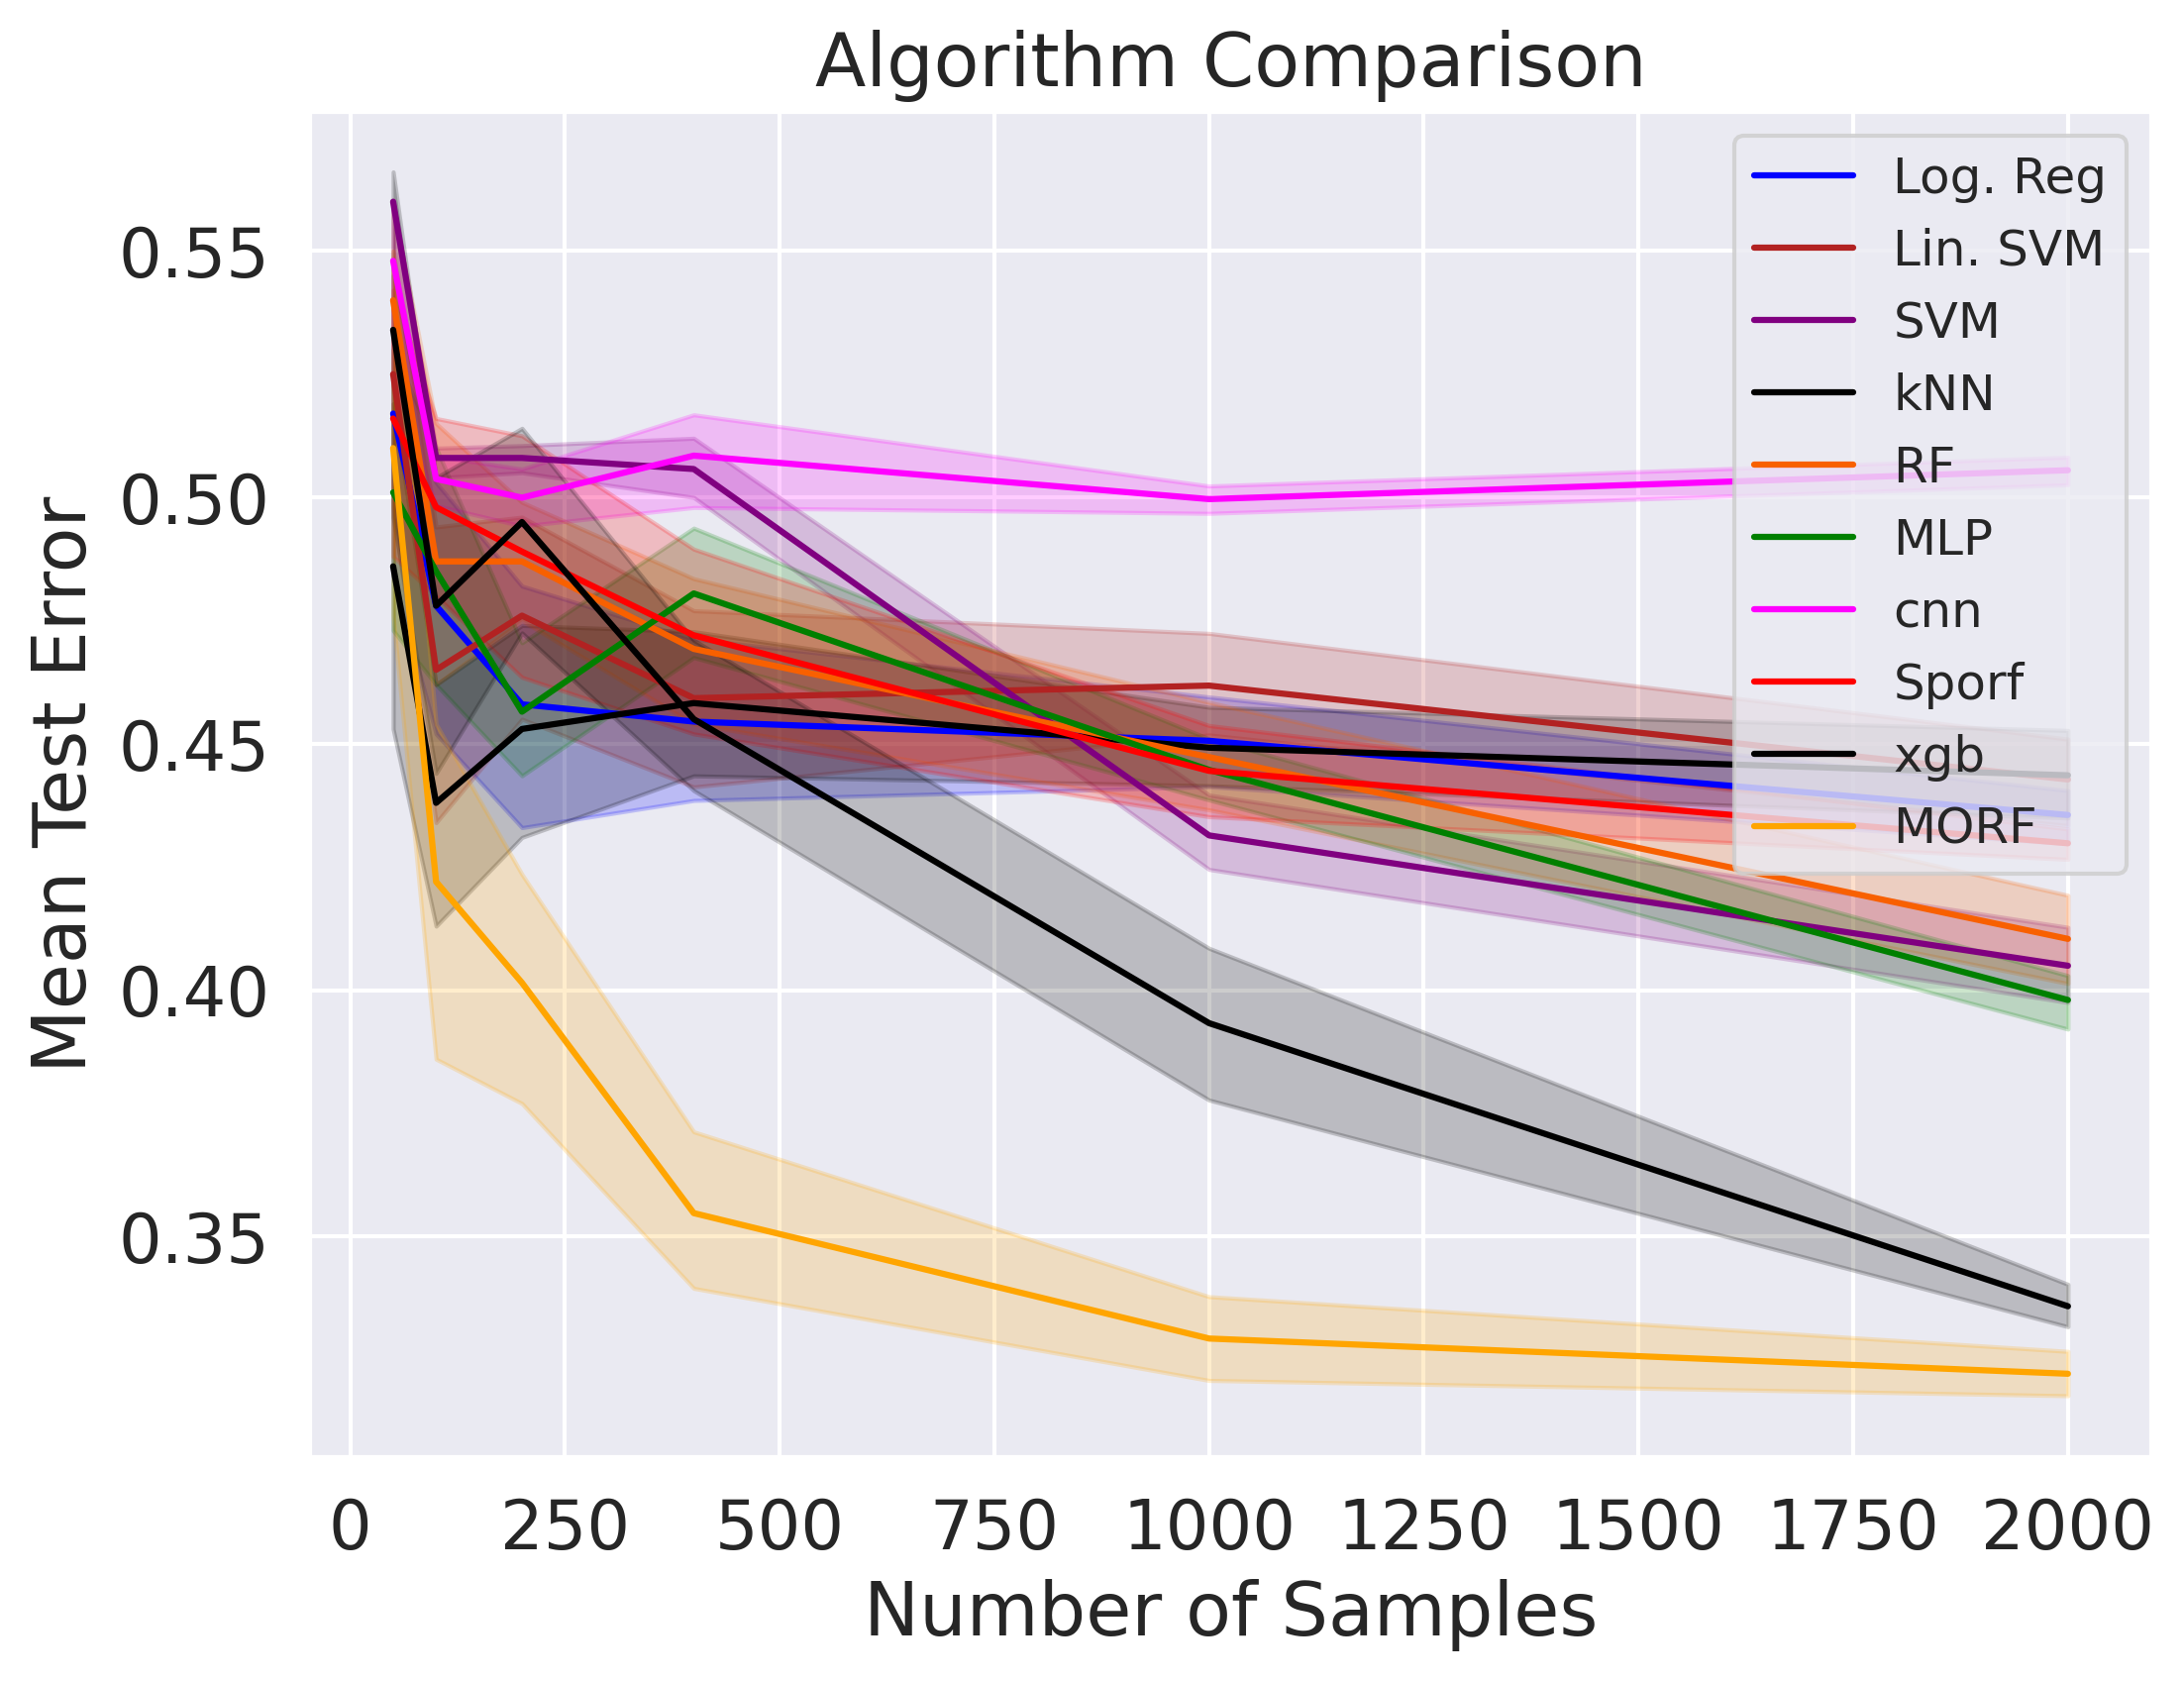

In [25]:
dat = pd.read_csv(fname)

dat["classifier"] = dat["classifier"].replace({"MT-MORF": "MORF"})
# dat = dat[dat["classifier"] != "xgb"]

names = {
    "Log. Reg": "blue",
    "Lin. SVM": "firebrick",
    "SVM": "purple",
    "kNN": "black",
    "RF": "#f86000",
    "MLP": "green",
    "cnn": "magenta",
    "Sporf": "red",
    "xgb": "black",
    "MORF": "orange",
}

sns.set(
    style="darkgrid", rc={"figure.figsize": [12, 8], "figure.dpi": 300}, font_scale=1.5
)
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x="n",
    y="Lhat",
    hue="classifier",
    data=dat,  # [dat["classifier"] == "MT-MORF"],
    ax=ax,
    palette=names,
)

plt.legend(loc="best", prop={"size": 12})
plt.title("Algorithm Comparison")
plt.ylabel("Mean Test Error")
plt.xlabel("Number of Samples")
plt.savefig(
    study_path
    / f"morf_ldssimulation_experiment_discontiguous_multivariategaussian_snrfactor-{snr_factor}_samplesize={n_samples}_ntrials={n_trials}_noisedim={noise_dim}.pdf",
    dpi=300,
    format="pdf",
)
plt.show()

# Increasing Noise Dimensionality

(100, 100)
1.016852756747122
0.523561888486325


<AxesSubplot:xlabel='Real part', ylabel='Imaginary part'>

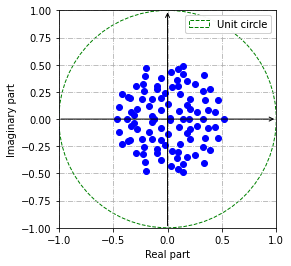

In [18]:
A = np.random.normal(size=(100, 100)) / np.linalg.norm(A, ord=2)

print(A.shape)
print(np.linalg.norm(A, ord=2))
print(np.abs(np.linalg.eigvals(A)).max())

lds = DiscreteLinearSystem(A)
lds.plot_eigs()

In [145]:
def _generate_random_input_pulse(n_chs, n_steps):
    """Apply an input signal for approximately 5 time points.

    The point at which the impulse signal is applied varies
    randomly between K and 2K.
    """
    # generate a C x T array
    ut = np.zeros((n_chs, n_steps))

    # randomly select a time point around the center
    # center_time = n_steps // 2
    K = 20
    rand_ind = np.random.randint(K, 2 * K, size=None)
    ut[:, rand_ind : rand_ind + 5] = 1

    # ut[:, center_time:center_time+2] = 1

    return ut


def generate_ar_samples2(A, cls, n_steps=1000, k=1, n_chs=3):
    """
    Generate multivariate time-series for 3 channels of length n_samples
    from a vector AR(1) model. Uncorrelated white noise channels are
    interspersed between the vector sequences.

    VAR(1) Model:
    y(t+1) = Ay(t) + Bu(t) + err(t)

    The noise is additive, not multiplicative.
    """
    # scale data along time w/ normalization
    scaler = StandardScaler()
    
    # signal that separates binary classes
    if cls == 0:
        B = np.array([[0.5, 0.1 * k, 0.1 * k], [0, 0.5, 0.1 * k], [0, 0, -0.5]])
    elif cls == 1:
        B = np.array([[0.5, 0, 0], [0, 0.5, 0], [0, 0, -0.5]])
    
    # sparse 
    if n_chs > 3:
        B_bump = np.zeros((n_chs, n_chs))
        B_bump[:3, :3] = B
        B = B_bump
    
    # create DT Linear system
    linsys = DiscreteLinearSystem(A=A, B=B)

    # generate input
    ut = _generate_random_input_pulse(n_chs, n_steps)
    
#     print(n_chs, A.shape, B.shape, ut.shape)
    # generate random initial condition and simulate what system would look like
    x0 = np.random.random((n_chs,))
    y = linsys.reconstruct(x0, ut, steps=n_steps, add_noise=False)
    assert y.shape == (n_chs, n_steps)
    #     print(np.linalg.norm(A))

    C = control.ctrb(A, B)
    np.testing.assert_almost_equal(np.linalg.norm(A, ord=2), 1., decimal=6)
    assert np.linalg.matrix_rank(C) == n_chs

    # add iid noise to the system simulation
    y_noise = np.random.normal(
        scale=0.5, size=(n_chs, n_steps)
    )  # add Gaussian noise?
    # print(f"max: {np.max(y)}, min: {np.min(y)}")
    y = y + y_noise

    # stack noise
#     y_noise = np.random.random((n_noise_chs, n_steps))
#     y = np.vstack(
#         (y[0, :], y_noise[0, :], y[1, :], y_noise[1, :], y[2, :], y_noise[2, :])
#     )
    
    # normalize along the time domain
    # y = scaler.fit_transform(y.T).T
#     print(y.shape)
    return y

In [146]:
def simulate_data(n, T, n_chs=6, cov_factor=1, test_size=0.5, random_state=None):
    # initialize data structures for train/test data
    X_train, Y_train = np.empty(shape=(0, n_chs, T)), np.empty(shape=(0))
    X_test, Y_test = np.empty(shape=(0, n_chs, T)), np.empty(shape=(0))

    # simulate over varying sizes of data sequence
    y = []
    X = []
    
    k = cov_factor
    if n_chs == 3:
        A = np.array(
            [
                [1.0, 0.7 * k, 0.6 * k],
                [-0.5 * k, 0.9, 0.5 * k],
                [-0.6 * k, -0.7 * k, 0.8],
            ]
        )
    else:
        A = np.random.normal(size=(n_chs, n_chs))
     
    # normalize the matrix to have marginally stable eigenspectrum
    A = A / np.linalg.norm(A, ord=2)

    # generate correlated multi-variate time series
    for i in range(int(n)):
        _x = generate_ar_samples2(A, cls=0, n_steps=T, k=cov_factor, n_chs=n_chs)
        X.append(_x)
        y.append(0)
    for i in range(int(n)):
        _x = generate_ar_samples2(A, cls=1, n_steps=T, k=cov_factor, n_chs=n_chs)
        X.append(_x)
        y.append(1)
    X = np.array(X)
    y = np.array(y)

    # perform training test split
    _X_train, _X_test, _y_train, _y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
#     print(_X_train.shape, _X_test.shape)
    X_train = np.vstack((X_train, _X_train))
    Y_train = np.hstack((Y_train, _y_train))
    X_test = np.vstack((X_test, _X_test))
    Y_test = np.hstack((Y_test, _y_test))

    X_train = X_train.reshape(_X_train.shape[0], -1)
    X_test = X_test.reshape(_X_test.shape[0], -1)
    return X_train, Y_train, X_test, Y_test

In [147]:
noise_dims = np.linspace(3, 30, 10).astype(int)

In [148]:
runList = [
    (n, run)
    for n in noise_dims  #                    for clf in zip(classifiers,
    #                                   [key for key in names])\
    for run in range(num_runs)
]
print(
    f"About to run {len(runList)} clf experiments: "
    f"sample size: {n_samples}, number channels: {n_chs}, "
    f"n_trials: {n_trials}, noise dim: {noise_dim}"
)

print(num_runs)

About to run 10 clf experiments: sample size: 100, number channels: 33, n_trials: 500, noise dim: 30
1


In [149]:
fname = (
    study_path
    / f"mtorfexp_ldssimulation_trunk_snrfactor={snr_factor}_samplesize={n_samples}_ntrials={n_trials}_noisedim={noise_dim}.csv"
)

print(fname)

/home/adam2392/hdd/Dropbox/morf-study/derivatives/mtmorf-simulation/mtorfexp_ldssimulation_trunk_snrfactor=1.0_samplesize=100_ntrials=500_noisedim=30.csv


In [151]:
n = 500 # number of samples
X_train, Y_train, X_test, Y_test = simulate_data(
            n, T, n_chs=noise_dim, cov_factor=1, test_size=test_size, random_state=random_state
        )
print(X_train.shape)
print(n, n_chs, T, noise_dim)

(500, 3000)
500 33 100 30


In [156]:
n = 500  # number of iid samples
T = 100  # size of trajectories
num_runs = 10  # number of monte carlos

overwrite = True

# Train each classifier on each dataset size, then test
# Prep output file:
if not Path(fname).exists() or overwrite:
    f = open(fname, "w+")
    f.write("classifier,noise_dim,Lhat,trainTime,testTime,iterate\n")
    f.flush()
else:
    f = open(fname, "a")

# loop over size of noise dimensionality
for jdx, noise_dim in enumerate(noise_dims):
    # for each exp, perform monte carlo
    for nidx in range(num_runs):
        # generate training and testing data
        indices = np.random.choice(np.arange(n_chs), size=n_chs, replace=False)
        assert len(np.unique(indices)) == n_chs
        X_train, Y_train, X_test, Y_test = simulate_data(
            n, T, n_chs=noise_dim, cov_factor=1, test_size=test_size, random_state=random_state
        )
    
        # for each experiment run on all classifiers
        names = {
            "Log. Reg": "blue",
            "Lin. SVM": "firebrick",
            "SVM": "purple",
            "kNN": "black",
            "RF": "#f86000",
            "MLP": "green",
            "cnn": "magenta",
            "Sporf": "red",
            "xgb": "black",
            "MORF": "orange",
        }
        
        classifiers = [
            LogisticRegression(random_state=random_state, n_jobs=ncores, solver="liblinear"),
            LinearSVC(),
            SVC(C=1.0, kernel="rbf", gamma="auto", random_state=random_state),
            KNeighborsClassifier(3, n_jobs=ncores),
            RandomForestClassifier(n_estimators=n_est, max_features="auto", n_jobs=ncores),
            MLPClassifier(
                hidden_layer_sizes=(n_est,), random_state=random_state, max_iter=1000
            ),
            KerasClassifier(_build_cnn, verbose=0),
            rerfClassifier(
                projection_matrix="RerF",
                max_features="auto",
                n_jobs=ncores,
                n_estimators=n_est,
                oob_score=False,
                random_state=random_state,
            ),
            GradientBoostingClassifier(n_estimators=n_est, random_state=random_state),
            #     rerfClassifier(
            #         projection_matrix="S-Rerf",
            #         max_features="auto",
            #         n_jobs=ncores,
            #         n_estimators=n_est,
            #         oob_score=False,
            #         random_state=0,
            #         image_height=n_chs,
            #         image_width=n_samples,
            #         patch_height_max=2,
            #         patch_height_min=1,
            #         patch_width_max=20,
            #         patch_width_min=5,
            #     ),
            rerfClassifier(
                projection_matrix="MT-MORF",
                max_features="auto",
                n_jobs=ncores,
                n_estimators=n_est,
                oob_score=False,
                random_state=random_state,
                image_height=n_chs,
                image_width=n_samples,
                patch_height_max=2,
                patch_height_min=1,
                patch_width_max=20,
                patch_width_min=5,
            ),
        ]

        for clf in zip(classifiers, [key for key in names]):
            X = X_train  # .flatten()
            y = Y_train  # .flatten()
#             Y_test = ytest[exp_idx]  # .flatten()
#             X_test = xtest[exp_idx]  # .flatten()
            #     X = X_train[:n]
            #     y = Y_train[:n]

            # training start time and end time
            trainStartTime = time.time()

            if isinstance(clf[0], KerasClassifier):
                X = X.reshape(-1, n_chs, n_samples, 1)
                X_test = X_test.reshape(-1, n_chs, n_samples, 1)

            clf[0].fit(X, y)
            trainEndTime = time.time()
            trainTime = trainEndTime - trainStartTime

            # testing start time and end time
            testStartTime = time.time()
            out = clf[0].predict(X_test)
            testEndTime = time.time()
            testTime = testEndTime - testStartTime

            # mean-error on the test set
            lhat = np.mean(np.not_equal(out, Y_test).astype(int))
            ####("variable,Lhat,trainTime,testTime,iterate")

            clf_id = clf[1]
            outputstr_row = f"{clf_id}, {noise_dim}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n"
            f.write(outputstr_row)
            f.flush()
f.close()

NameError: name 'f' is not defined